In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from scipy.optimize import minimize

Load Data

In [2]:
# Load drafted players list
with open('mls_2025_drafted_players.txt', 'r') as file:
    mls_2025_drafted_players = [line.strip() for line in file]

# Load player and team data
player_df = pd.read_csv('d1_player_stats.csv')
team_df = pd.read_csv('ncaa_ratings.csv')

# Clean up data
player_df = player_df.drop(columns=['Unnamed: 0'])
team_df = team_df.drop(columns=['Unnamed: 0'])
player_df = player_df[player_df['Position'] != 'Goalkeeper']
player_df = player_df[player_df['Minutes Played'] >= 300]
#player_df = player_df[player_df['Position'] != 'Defender']

player_df['Shot Accuracy'] = player_df.apply(
    lambda row: row['Shots On Target'] / row['Shots'] if row['Shots'] > 0 else 0,
    axis=1
)

# Merge player and team data
merged_df = player_df.merge(team_df, on='Team', suffixes=('_player', '_team'))


In [3]:
per90_stats = ['Goals', 'Assists', 'Shots', 'Shots On Target', 'Fouls Won']
for stat in per90_stats:
    merged_df[f'{stat}_per90'] = merged_df[stat] / (merged_df['Minutes Played'] / 90)

In [4]:
# Normalize statistics
merged_df['Norm_Goals'] = merged_df['Goals_per90'] / merged_df['Goals_per90'].max()
merged_df['Norm_Assists'] = merged_df['Assists_per90'] / merged_df['Assists_per90'].max()
merged_df['Norm_Shots'] = merged_df['Shots_per90'] / merged_df['Shots_per90'].max()
merged_df['Norm_Shots_On_Target'] = merged_df['Shots On Target_per90'] / merged_df['Shots On Target_per90'].max()
merged_df['Norm_Fouls_Won'] = merged_df['Fouls Won_per90'] / merged_df['Fouls Won_per90'].max()
merged_df['Norm_Minutes_Played'] = merged_df['Minutes Played'] / merged_df['Minutes Played'].max()
merged_df['Norm_ATT'] = merged_df['ATT'] / merged_df['ATT'].max()
merged_df['Norm_DEF'] = merged_df['DEF'] / merged_df['DEF'].max()

# Calculate the percentage of team minutes played
team_total_minutes = merged_df.groupby('Team')['Minutes Played'].transform('sum')
merged_df['Team_Minutes_Played_Percentage'] = merged_df['Minutes Played'] / team_total_minutes


Objective Function and Optimization

Calculate and Scale the Ratings

In [5]:
# Initial weights and constraints
initial_weights = [
    0.3, 0.2, 0.1, 0.25, 0.15,  # Forward weights
    0.15, 0.25, 0.05, 0.3, 0.25,  # Midfielder weights
    0.05, 0.1, 0.05, 0.6, 0.2   # Defender weights
]
bounds = [(0, 1)] * len(initial_weights)
constraints = [
    {'type': 'eq', 'fun': lambda w: sum(w[0:5]) - 1},  # Forward
    {'type': 'eq', 'fun': lambda w: sum(w[5:10]) - 1},  # Midfielder
    {'type': 'eq', 'fun': lambda w: sum(w[10:15]) - 1}  # Defender
]

# Objective function
def objective(weights):
    updated_weights = {
        'Forward': {'Goals': weights[0], 'Assists': weights[1], 'Shots': weights[2], 'Team_Att': weights[3], 'Fouls_Won': weights[4]},
        'Midfielder': {'Goals': weights[5], 'Assists': weights[6], 'Shots': weights[7], 'Team_Att_Def': weights[8], 'Fouls_Won': weights[9]},
        'Defender': {'Goals': weights[10], 'Assists': weights[11], 'Shots': weights[12], 'Team_Def': weights[13], 'Fouls_Won': weights[14]}
    }

    def calculate_rating(row):
        if row['Position'] == 'Forward':
            return (
                row['Norm_Goals'] * updated_weights['Forward']['Goals'] +
                row['Norm_Assists'] * updated_weights['Forward']['Assists'] +
                row['Norm_Shots'] * updated_weights['Forward']['Shots'] +
                row['Norm_Fouls_Won'] * updated_weights['Forward']['Fouls_Won'] +
                row['Norm_ATT'] * row['Team_Minutes_Played_Percentage'] * updated_weights['Forward']['Team_Att']
            ) * 100
        elif row['Position'] == 'Midfielder':
            return (
                row['Norm_Goals'] * updated_weights['Midfielder']['Goals'] +
                row['Norm_Assists'] * updated_weights['Midfielder']['Assists'] +
                row['Norm_Shots'] * updated_weights['Midfielder']['Shots'] +
                row['Norm_Fouls_Won'] * updated_weights['Midfielder']['Fouls_Won'] +
                ((row['Norm_ATT'] + row['Norm_DEF']) / 2) * row['Team_Minutes_Played_Percentage'] * updated_weights['Midfielder']['Team_Att_Def']
            ) * 100
        elif row['Position'] == 'Defender':
            return (
                row['Norm_Goals'] * updated_weights['Defender']['Goals'] +
                row['Norm_Assists'] * updated_weights['Defender']['Assists'] +
                row['Norm_Shots'] * updated_weights['Defender']['Shots'] +
                row['Norm_Fouls_Won'] * updated_weights['Defender']['Fouls_Won'] +
                row['Norm_DEF'] * row['Team_Minutes_Played_Percentage'] * updated_weights['Defender']['Team_Def']
            ) * 100
        else:
            return 0

    merged_df['Overall_Rating'] = merged_df.apply(calculate_rating, axis=1)
    df = merged_df.copy()
    df['MAX'] = ((df['Overall_Rating'] - df['Overall_Rating'].min()) /
                 (df['Overall_Rating'].max() - df['Overall_Rating'].min()) * 100).fillna(0)
    drafted_players_df = df[df['Name'].isin(mls_2025_drafted_players)]
    return -drafted_players_df['MAX'].mean()

# Optimize weights
result = minimize(objective, initial_weights, bounds=bounds, constraints=constraints, method='SLSQP')
optimized_weights = result.x
print("Optimized Weights:", optimized_weights)


Optimized Weights: [1.22615086e-02 6.83878282e-03 4.27845135e-05 8.95389259e-01
 8.54680422e-02 4.99482855e-02 1.71725289e-02 6.40188592e-03
 8.22166396e-01 1.04311327e-01 1.51994820e-03 4.78093692e-02
 7.58428390e-02 7.54410683e-01 1.20417325e-01]


In [6]:
# Organize optimized weights into a dictionary
normalized_values = optimized_weights  # Get optimized weights from the minimize() result

weights = {
    'Forward': {
        'Goals': normalized_values[0],
        'Assists': normalized_values[1],
        'Shots': normalized_values[2],
        'Team_Att': normalized_values[3],
        'Fouls_Won': normalized_values[4]
    },
    'Midfielder': {
        'Goals': normalized_values[5],
        'Assists': normalized_values[6],
        'Shots': normalized_values[7],
        'Team_Att_Def': normalized_values[8],
        'Fouls_Won': normalized_values[9]
    },
    'Defender': {
        'Goals': normalized_values[10],
        'Assists': normalized_values[11],
        'Shots': normalized_values[12],
        'Team_Def': normalized_values[13],
        'Fouls_Won': normalized_values[14]
    }
}

# Define function to calculate player rating based on position
def calculate_rating(row):
    if row['Position'] == 'Forward':
        return (
            row['Norm_Goals'] * weights['Forward']['Goals'] +
            row['Norm_Assists'] * weights['Forward']['Assists'] +
            row['Norm_Shots'] * weights['Forward']['Shots'] +
            row['Norm_Fouls_Won'] * weights['Forward']['Fouls_Won'] +
            row['Norm_ATT'] * row['Team_Minutes_Played_Percentage'] * weights['Forward']['Team_Att']
        ) * 100
    elif row['Position'] == 'Midfielder':
        return (
            row['Norm_Goals'] * weights['Midfielder']['Goals'] +
            row['Norm_Assists'] * weights['Midfielder']['Assists'] +
            row['Norm_Shots'] * weights['Midfielder']['Shots'] +
            row['Norm_Fouls_Won'] * weights['Midfielder']['Fouls_Won'] +
            ((row['Norm_ATT'] + row['Norm_DEF']) / 2) * row['Team_Minutes_Played_Percentage'] * weights['Midfielder']['Team_Att_Def']
        ) * 100
    elif row['Position'] == 'Defender':
        return (
            row['Norm_Goals'] * weights['Defender']['Goals'] +
            row['Norm_Assists'] * weights['Defender']['Assists'] +
            row['Norm_Shots'] * weights['Defender']['Shots'] +
            row['Norm_Fouls_Won'] * weights['Defender']['Fouls_Won'] +
            row['Norm_DEF'] * row['Team_Minutes_Played_Percentage'] * weights['Defender']['Team_Def']
        ) * 100
    else:
        return 0  # Default for unknown positions


# Apply the rating calculation
merged_df['Overall_Rating'] = merged_df.apply(calculate_rating, axis=1)

# Apply logarithmic scaling to compress rating range
merged_df['Log_Rating'] = np.log1p(merged_df['Overall_Rating'])

# Normalize ratings to a 0-100 range
log_rating_min = merged_df['Log_Rating'].min()
log_rating_max = merged_df['Log_Rating'].max()
merged_df['MAX'] = (
    (merged_df['Log_Rating'] - log_rating_min) / (log_rating_max - log_rating_min) * 100
).astype(int)


In [7]:
df = merged_df[['Name', 'Team', 'Position', 'Goals', 'Assists', 'Shots', 'Fouls Won', 
                'Shots On Target', 'Shot Accuracy', 'Minutes Played', 'Overall_Rating', 'MAX']]
df = df.sort_values(by='MAX', ascending=False).reset_index(drop=True)
df['Rank'] = df.index + 1  # Create a Rank column starting from 1
#df.to_csv(r"PlayerRatings.csv", index=False)


In [8]:
df[(df['Position'] == 'Defender')].sort_values(by='MAX', ascending=False).head(25)

,Name,Team,Position,Goals,Assists,Shots,Fouls Won,Shots On Target,Shot Accuracy,Minutes Played,Overall_Rating,MAX,Rank
0,Ben Foulks,Creighton,Defender,0,1,5,29,3,0.600000,463,9.922218,100,1
5,Devonte Richards,Central Ark.,Defender,7,5,49,23,25,0.510204,1447,9.922196,99,6
4,Chambron Pinho,SMU,Defender,6,6,45,26,16,0.355556,1366,9.700620,99,5
8,Noah De Blasis,Louisville,Defender,0,1,8,69,5,0.625000,1260,9.445202,98,9
13,Joao Roberto,Marshall,Defender,2,1,14,22,5,0.357143,503,9.637941,98,14
15,Cesar Banacloy,Drexel,Defender,0,2,17,17,5,0.294118,579,9.377873,97,16
17,Nemo Philipp,UC Santa Barbara,Defender,2,4,20,17,9,0.450000,679,9.360294,97,18
24,Philip Naef,UCLA,Defender,1,10,14,7,6,0.428571,744,9.059852,96,25
26,Pascal Leatherman,Milwaukee,Defender,1,1,6,24,4,0.666667,450,9.135678,96,27
25,Dominic De Almeida,California Baptist,Defender,0,1,2,62,0,0.000000,990,9.107159,96,26


In [9]:
df[(df['Goals'] <= 10) & (df['Position'] == 'Midfielder')].sort_values(by='MAX', ascending=False).head(25)

,Name,Team,Position,Goals,Assists,Shots,Fouls Won,Shots On Target,Shot Accuracy,Minutes Played,Overall_Rating,MAX,Rank
9,Grant Paskus,NIU,Midfielder,1,3,10,58,4,0.400000,1184,9.438349,98,10
11,Hector Taboada,Kansas City,Midfielder,9,2,33,13,19,0.575758,691,9.455579,98,12
12,Tj Kahoalii,Louisville,Midfielder,2,3,13,50,4,0.307692,937,9.435336,98,13
10,Pablo Hempelmann-Perez,Hofstra,Midfielder,1,2,8,25,3,0.375000,362,9.594901,98,11
16,Owen Smith,Western Mich.,Midfielder,6,17,24,42,14,0.583333,1395,9.217211,97,17
20,Steven Cordova,Presbyterian,Midfielder,1,6,17,44,4,0.235294,1409,9.273341,97,21
22,Ethan Ballek,South Carolina,Midfielder,9,4,50,26,23,0.460000,1296,8.927509,96,23
23,Martin Bakken,Dayton,Midfielder,9,10,44,24,16,0.363636,1670,8.974464,96,24
27,Patrick Short,Drexel,Midfielder,5,10,37,31,9,0.243243,1296,9.147088,96,28
33,Caio Cavaletti,Marist,Midfielder,2,2,27,51,8,0.296296,1044,8.762360,95,34


In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.patches import Rectangle
from scipy.stats import percentileofscore
from mplsoccer import FontManager

# --------------------
# Step 1: Per 90 Stats + Percentiles by Position
# --------------------
per90_df = df.copy()
per90_cols = ['Goals', 'Assists', 'Shots', 'Fouls Won', 'Shots On Target']

# Compute per 90
for col in per90_cols:
    per90_df[f'{col}_per90'] = per90_df[col] / (per90_df['Minutes Played'] / 90)

# Use original Shot Accuracy
per90_df['Shot Accuracy'] = df['Shot Accuracy']

# Compute percentiles by position
for col in per90_cols:
    col_per90 = f'{col}_per90'
    pct_col = f'{col}_pct'
    per90_df[pct_col] = per90_df.apply(
        lambda row: percentileofscore(
            per90_df[per90_df['Position'] == row['Position']][col_per90].dropna(),
            row[col_per90]
        ) if pd.notnull(row[col_per90]) else np.nan,
        axis=1
    )

# Shot Accuracy percentile by position
per90_df['Shot Accuracy_pct'] = per90_df.apply(
    lambda row: percentileofscore(
        per90_df[per90_df['Position'] == row['Position']]['Shot Accuracy'].dropna(),
        row['Shot Accuracy']
    ) if pd.notnull(row['Shot Accuracy']) else np.nan,
    axis=1
)

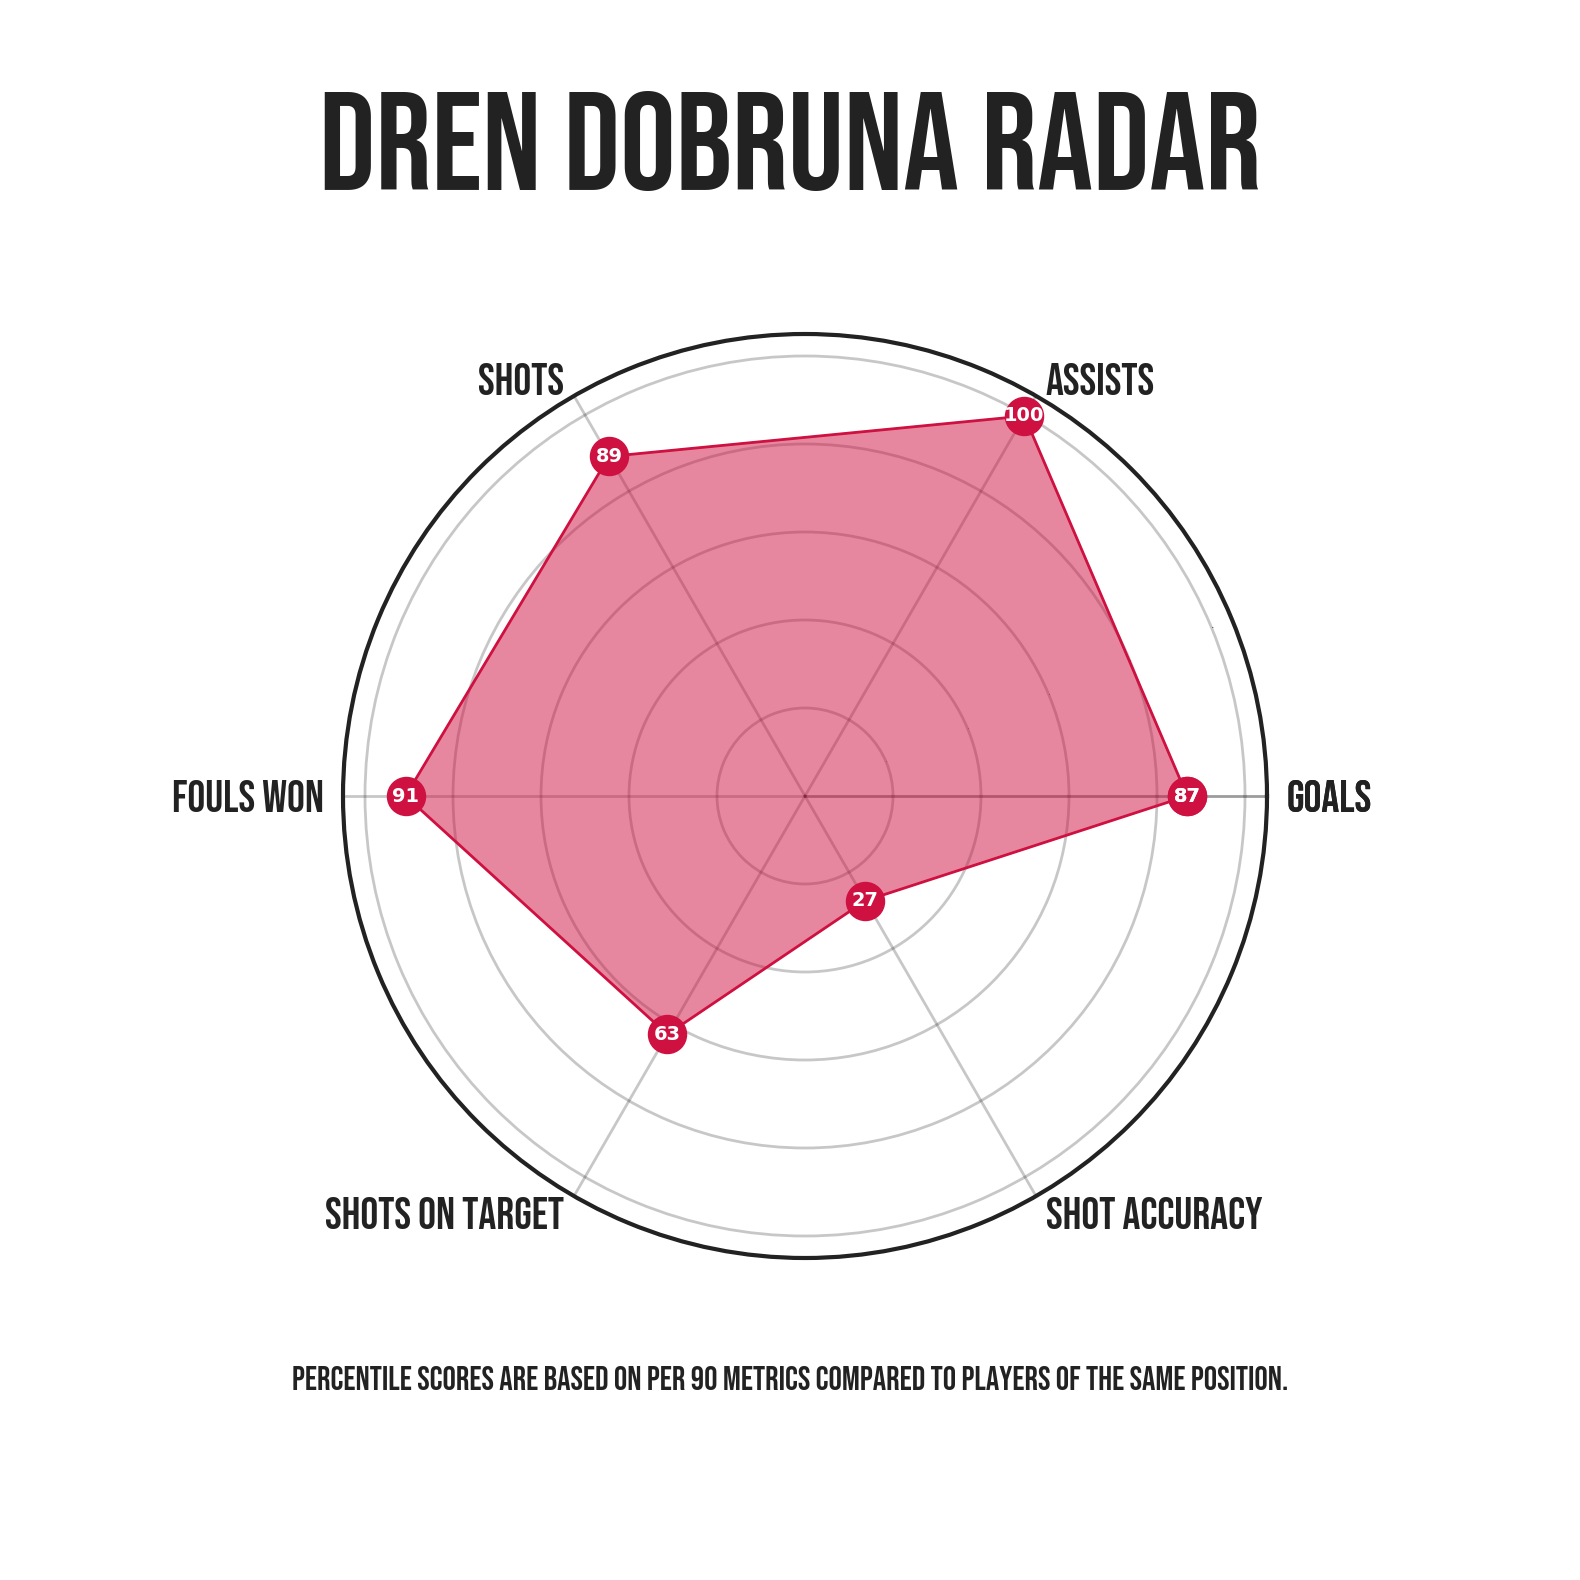

In [24]:
# --------------------
# Step 2: Radar Chart for One Player (with point labels)
# --------------------
player_name = "Dren Dobruna"
player_row = per90_df[per90_df['Name'] == player_name].iloc[0]

# Radar metrics
columns = ['Goals_pct', 'Assists_pct', 'Shots_pct', 'Fouls Won_pct', 'Shots On Target_pct', 'Shot Accuracy_pct']
labels = ['Goals', 'Assists', 'Shots', 'Fouls Won', 'Shots On Target', 'Shot Accuracy']
values = [player_row[col] for col in columns]
values[3] -= 1
values += [values[0]]  # close radar
labels += [labels[0]]
label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(labels))

# Optional: Load font
font_url = 'https://raw.githubusercontent.com/google/fonts/main/ofl/bebasneue/BebasNeue-Regular.ttf'
fm = FontManager(font_url)

# Radar style preset
preset = {
    "background": "#FFFFFF",
    "text_color": "#222222",
    "label_color": "#222222",
    "player_one_color": "#CE1141",
    "grid_color": "#222222"
}

# Plotting
fig, ax = plt.subplots(figsize=(12, 12), subplot_kw=dict(polar=True))
fig.patches.append(Rectangle((-0.15, -0.15), 1.30, 1.30,
                             transform=fig.transFigure,
                             color=preset["background"], zorder=-1))
fig.patch.set_facecolor(preset["background"])
ax.set_facecolor(preset["background"])

# Radar lines
ax.plot(label_loc, values, lw=2, label=player_name,
        color=preset["player_one_color"], zorder=2)
ax.fill(label_loc, values, alpha=0.5, color=preset["player_one_color"], zorder=3)
ax.scatter(label_loc, values, color=preset["player_one_color"], s=750, zorder=5)

# Percentile labels on each radar point
for angle, value in zip(label_loc, values):
    ax.text(
        angle, value,  # position slightly outside the circle
        f"{int(round(value))}",
        ha='center', va='center',
        fontsize=14, color='white', fontweight='bold',
        zorder=6
    )

# Axis labels
plt.thetagrids(np.degrees(label_loc), labels,
               fontproperties=fm.prop, color=preset["label_color"], fontsize=32)
ax.tick_params(axis='y', which='major', labelsize=0)
ax.spines['polar'].set_linewidth(3)
ax.spines['polar'].set_color(preset["grid_color"])
ax.grid(color=preset["grid_color"], alpha=0.25, linewidth=2)

# Rotate label text
angles = np.degrees(label_loc)
for label, angle in zip(ax.get_xticklabels(), angles):
    if 90 < angle < 270:
        label.set_rotation(angle + 180)
        label.set_ha("right")
    else:
        label.set_rotation(angle)
        label.set_ha("left")
    label.set_va("center")

# Title
fig.text(0.5, 1.0, f"{player_name} Radar", fontsize=100,
         ha='center', color=preset["text_color"], fontproperties=fm.prop)

fig.text(0.5, 0, f"Percentile scores are based on Per 90 metrics compared to players of the same position.", fontsize=24,
         ha='center', color=preset["text_color"], fontproperties=fm.prop)

ax.set_ylim(0, 105) 
plt.savefig(f"radars/{player_name}_radar.png", dpi=300, bbox_inches='tight')
plt.show()


In [22]:
player_row

Name                     Dren Dobruna
Team                            Siena
Position                     Defender
Goals                               2
Assists                            10
Shots                              14
Fouls Won                          24
Shots On Target                     3
Shot Accuracy                0.214286
Minutes Played                   1206
Overall_Rating               8.052817
MAX                                92
Rank                               64
Goals_per90                  0.149254
Assists_per90                0.746269
Shots_per90                  1.044776
Fouls Won_per90              1.791045
Shots On Target_per90        0.223881
Goals_pct                   86.863271
Assists_pct                 99.731903
Shots_pct                   89.097408
Fouls Won_pct               91.778374
Shots On Target_pct         62.555853
Shot Accuracy_pct           27.479893
Name: 63, dtype: object